In [1]:
from sklearn.model_selection import train_test_split #para dividir sets de entrenamiendo y prueba

import numpy as np
import cv2
import matplotlib.pyplot as plt
from os import listdir 
import pandas as pd

from skimage.filters import sobel  #filtro para la deteccion de bordes
from skimage.feature import graycomatrix, graycoprops  #la primera calcula la glcm y la segunda las metricas de una glcm
#from skimage.measure import shannon_entropy

from sklearn.metrics import roc_curve, RocCurveDisplay, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay


In [2]:
brodatz_db = listdir('Dataset')

In [3]:
print(brodatz_db)

['D16.bmp', 'D6.bmp', 'D64.bmp', 'D49.bmp', 'D46.bmp', 'D101.bmp']


In [4]:
def preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = cv2.resize(image, (512,512), interpolation= cv2.INTER_LINEAR)
    return image

In [5]:
images = []
'''Leyendo las imagenes'''
for image_name in brodatz_db:
    image = cv2.imread(f'Dataset/{image_name}')
    images.append(preprocessing(image))

Definiendo regiones de las secciones de entrenamiento

In [6]:
global WINDOW_TRAIN_SIZE   #tamaño de la ventana para los sets de entrenamiento 
WINDOW_TRAIN_SIZE = 50  

#global WINDOW_TEST_SIZE   #tamaño de la ventana para los sets de entrenamiento 
#WINDOW_TEST_SIZE = 256  

'''Obtendremos las regiones caracteristicas de la textura por fuera y construiremos una ventana del tamaño 
determinado, los vectores se definen en un programa externo '''

def create_windows(image, coords, size = WINDOW_TRAIN_SIZE):
    window = []
    for loc in coords:
        w = image[loc[0]:loc[0] + size, 
                    loc[1]:loc[1] + size]

        w = w.reshape(size,size)
        window.append(w)
        

    return np.array(window)

In [7]:
#COORDENADA PARA LA REGION DE PRUEBA (TODAS LAS IMAGENES) 
#T_TEST = [(0,256)]

In [8]:
#LAS COORDENADAS PARA LA REGION DE ENTRENAMIENTO 
T1 = [(42,29),(173,39),(439,96),(559,230),(493,439),(349,227)]
T2 = [(16,21),(245,76),(570,446),(545,283),(560,191),(461,161)]
T3 = [(67,184),(142,180),(425,57),(443,117),(249,423),(190,550)]
T4 = [(37,45),(449,142),(307,248),(557,330),(208,257),(553,581)]
T5 = [(88,137),(298,158),(242,342),(311,321),(478,256),(234,489)]
T6 = [(50,36),(293,85),(131,353),(399,353),(284,500),(569,313)]

In [9]:
'''AGRENGANDO VENTANAS DE CADA TEXTURA'''

windows = []

windows.append(create_windows(images[0], T1))
windows.append(create_windows(images[1], T2))
windows.append(create_windows(images[2], T3))
windows.append(create_windows(images[3], T4))
windows.append(create_windows(images[4], T5))
windows.append(create_windows(images[5], T6))

windows = np.array(windows)

In [10]:
data = windows.reshape(-1,WINDOW_TRAIN_SIZE,WINDOW_TRAIN_SIZE)

In [11]:
'''Obteniendo las labels de cada texel obtenido, como se agregaron por orden 1,2,3,4,5,6 se seguira el mismo criterio
para crear las etiquetas '''
labels = np.array([[f'T{i}'] * 6 for i in range(1,7)])
labels = labels.reshape(-1)
labels

array(['T1', 'T1', 'T1', 'T1', 'T1', 'T1', 'T2', 'T2', 'T2', 'T2', 'T2',
       'T2', 'T3', 'T3', 'T3', 'T3', 'T3', 'T3', 'T4', 'T4', 'T4', 'T4',
       'T4', 'T4', 'T5', 'T5', 'T5', 'T5', 'T5', 'T5', 'T6', 'T6', 'T6',
       'T6', 'T6', 'T6'], dtype='<U2')

In [12]:
data.shape

(36, 50, 50)

In [13]:
labels.shape

(36,)

Definiendo sets de entrenamiento y prueba

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

Obteniendo GLCM2 y metricas de segundo orden 

In [15]:
from operator import concat


def feature_extractor(data, set_name): 
    '''Esta funcion se encargara de la creacion de las matrices de GLCM2 y la extraccion de las caracteristicas de las mismas
    ademas de almacenar los resultados en un dataframe que se podra utilizar a continuación como la información de 
    entrenamiento

    Los calculos de GLCM que se usaran son: 

    distancia   |   grados
    1           |   0
    3           |   0
    0           |   pi/4
    0           |   pi/2


    Parameters
    ----------
        * data [list] : set de imagenes
        * set_name [str] : nombra al set resultante entre entrenamiento o prueba
        
    Returns
    ----------
        * dataset [DataFrame] : Dataframe de la extraccion de caracteristicas de las matrices de GLCM2
'''
    dataset = pd.DataFrame() #definimos un dataframe (excel) para guardar las caracteristicas

    for image in data:
        #print(f'{i}    {image.shape}')
        row = pd.DataFrame()  #dataframe auxiliar para almacenar una fila
        
        #Metricas para la primera GLCM
        GLCM = graycomatrix(image, [1], [0])      
        GLCM_Energy = graycoprops(GLCM, 'energy')[0]
        row['energy1'] = GLCM_Energy
        GLCM_corr = graycoprops(GLCM, 'correlation')[0]
        row['correlation1'] = GLCM_corr
        GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
        row['dissimilarity1'] = GLCM_diss
        GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
        row['homogeneity1'] = GLCM_hom
        GLCM_contr = graycoprops(GLCM, 'contrast')[0]
        row['contrast1'] = GLCM_contr

        #Metricas para la segunda GLCM
        GLCM2 = graycomatrix(image, [3], [0])      
        GLCM_Energy2 = graycoprops(GLCM2, 'energy')[0]
        row['energy2'] = GLCM_Energy2
        GLCM_corr2 = graycoprops(GLCM2, 'correlation')[0]
        row['correlation2'] = GLCM_corr2
        GLCM_diss2 = graycoprops(GLCM2, 'dissimilarity')[0]
        row['dissimilarity2'] = GLCM_diss2
        GLCM_hom2 = graycoprops(GLCM2, 'homogeneity')[0]
        row['homogeneity2'] = GLCM_hom2
        GLCM_contr2 = graycoprops(GLCM2, 'contrast')[0]
        row['contrast2'] = GLCM_contr2

        #Metricas para la tercera GLCM
        GLCM3 = graycomatrix(image, [0], [np.pi/4])      
        GLCM_Energy3 = graycoprops(GLCM3, 'energy')[0]
        row['energy3'] = GLCM_Energy3
        GLCM_corr3 = graycoprops(GLCM3, 'correlation')[0]
        row['correlation3'] = GLCM_corr3
        GLCM_diss3 = graycoprops(GLCM3, 'dissimilarity')[0]
        row['dissimilarity3'] = GLCM_diss3
        GLCM_hom3 = graycoprops(GLCM3, 'homogeneity')[0]
        row['homogeneity3'] = GLCM_hom3
        GLCM_contr3 = graycoprops(GLCM3, 'contrast')[0]
        row['contrast3'] = GLCM_contr3

        #Metricas para la cuarta GLCM
        GLCM4 = graycomatrix(image, [0], [np.pi/2])      
        GLCM_Energy4 = graycoprops(GLCM4, 'energy')[0]
        row['energy4'] = GLCM_Energy4
        GLCM_corr4 = graycoprops(GLCM4, 'correlation')[0]
        row['correlation4'] = GLCM_corr4
        GLCM_diss4 = graycoprops(GLCM4, 'dissimilarity')[0]
        row['dissimilarity4'] = GLCM_diss4
        GLCM_hom4 = graycoprops(GLCM4, 'homogeneity')[0]
        row['homogeneity4'] = GLCM_hom4
        GLCM_contr4 = graycoprops(GLCM4, 'contrast')[0]
        row['contrast4'] = GLCM_contr4

        dataset = pd.concat([dataset, row])
    
    dataset.to_csv(f'metrics_{set_name}.csv')
    
    return dataset 

In [16]:
train_features = feature_extractor(X_train, 'train')
#n_features = image_features.shape[1]
train_features = np.expand_dims(train_features, axis=0)
train_features = np.reshape(train_features, (X_train.shape[0], -1))  #nueva forma de imagen-caracteristicas

In [17]:
n_features = train_features.shape[1]
n_features

20

Ajuste de los datos de prueba

In [18]:
test_features = feature_extractor(X_test, 'test')
test_features = np.expand_dims(test_features, axis=0)
test_features = np.reshape(test_features, (X_test.shape[0], -1))  #nueva forma de imagen-caracteristicas

USO DE CLASIFICADORES

In [19]:
def calculateCM(y_true, y_pred, title, labels=['T1','T2','T3','T4','T5','T6']):
    cm = confusion_matrix(y_true, y_pred, labels = labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['T1','T2','T3','T4','T5','T6'])
    #disp.ax.set_title(title)
    disp.plot()
    plt.show()

SVM

In [20]:
'''SVM'''

from sklearn import svm
SVM_model = svm.SVC(decision_function_shape='ovo')  #Para la clasificacion multiclase
SVM_model.fit(train_features, y_train)

SVC(decision_function_shape='ovo')

In [21]:
y_pred = SVM_model.predict(test_features)

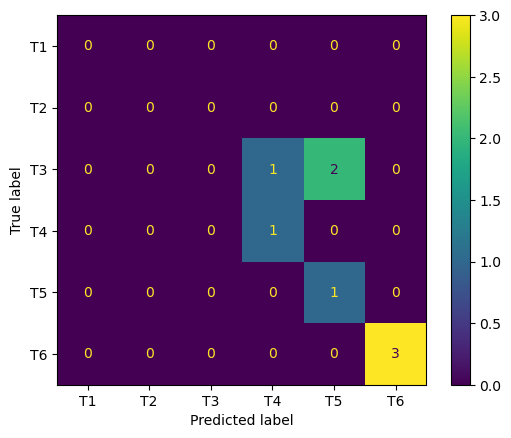

In [22]:
'''La matriz de confusion se refiere a las coincidencias entre los valores predecidos y los reales entre cada una 
de las clases'''

calculateCM(y_test, y_pred, 'SVM')

KNN

In [23]:
y_test

array(['T6', 'T3', 'T5', 'T6', 'T3', 'T6', 'T4', 'T3'], dtype='<U2')

In [24]:
from sklearn.neighbors import KNeighborsClassifier 

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(train_features, y_train)
y_pred = neigh.predict(test_features, )

/Users/rcs/opt/anaconda3/envs/REC-PATRONES/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


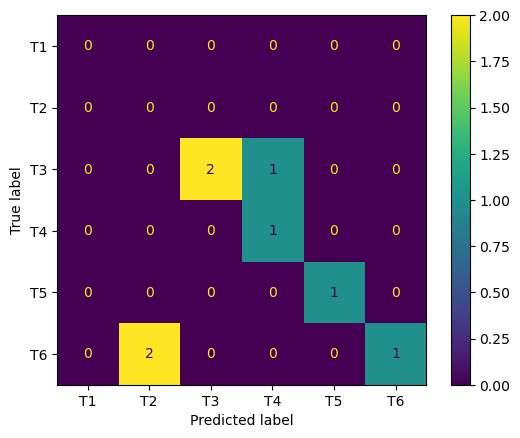

In [25]:
calculateCM(y_test, y_pred, 'KNN')

Naive Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train_features, y_train)

GaussianNB()

In [27]:
y_pred = clf.predict(test_features)

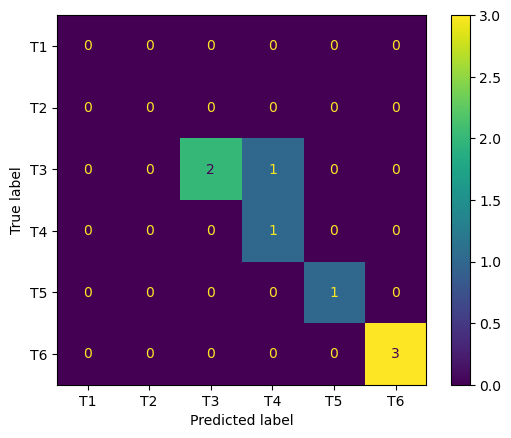

In [28]:
calculateCM(y_test, y_pred, 'NAIVE BAYES')

Parte B

In [29]:
composed_images_names = listdir('imagenes_compuestas')
composed_images_names

['imgCompuesta2.png', 'imgCompuesta3.png', 'imgCompuesta1.png']

In [30]:
composed_images = []   #Composed X_test

'''Leyendo las imagenes'''
for image_name in composed_images_names:
    image = cv2.imread(f'imagenes_compuestas/{image_name}')
    composed_images.append(preprocessing(image))   #aplicamos el preprocesamiento 

In [31]:
'''Usando el algoritmo de ventanas deslizantes vamos a obtener nuevas ventanas como set de prueba y probaremos 
los clasificadores'''

#CAMBIAR AQUI PARA CAMBIAR LOS TAMAÑOS DE MUESTRAS
im = composed_images[0]   # cambiar el indice para probar otra imagen 
W = im.shape[0]//8   #para el tamaño de ventana que se definio para las de entrenamiento
H = im.shape[1]//8

CX_test = []
Cy_test = []

'''tomamos una region de hasta M y N en un valor que se itera doblemente entre el tamaño de ancho y 
alto respectivamente'''
for x in range(0,im.shape[0],W):
    for y in range(0,im.shape[1],H):
        CX_test.append(im[x:x+W,y:y+H])

        if x in range(0,im.shape[0]//2) and y in range(0,im.shape[0]//2):  #cuadrante 1
            Cy_test.append('T1')

        elif x in range(im.shape[0]//2,im.shape[0]) and y in range(im.shape[0]//2,im.shape[0]): #cuadrante 4
            Cy_test.append('T6')

        elif x in range(im.shape[0]//2,im.shape[0]) and y in range(0,im.shape[0]//2): #cuadrante 2
            Cy_test.append('T5')

        else: 
            Cy_test.append('T3') #cuadrante 3


#CX_test.append([im[x:x+W,y:y+H] for x in range(0,im.shape[0],W) for y in range(0,im.shape[1],H)])

CX_test = np.array(CX_test)
#CX_test = CX_test.reshape(-1,40,40)

Cy_test = np.array(Cy_test)
#CX_test = CX_test.reshape(-1,40,40)

In [32]:
CX_features_test = feature_extractor(CX_test, 'composed_images')

In [33]:
CX_features_test = feature_extractor(CX_test, 'test')
CX_features_test = np.expand_dims(CX_features_test, axis=0)
CX_features_test = np.reshape(CX_features_test, (CX_test.shape[0], -1))  #nueva forma de imagen-caracteristicas

PRUEBA DE CLASIFICADORES PARA PARTE B

In [34]:
def show_gallery(images, title):
    for num, image in enumerate(images):
        plt.subplot(1,2,num+1)
        plt.title(title)
        plt.axis('off')
        plt.imshow(image)

In [35]:
import copy

def segmentate_classes(y_pred, tested_image, title):
    segmented_image = tested_image

    W = tested_image.shape[0]//8   #para el tamaño de ventana que se definio para las de entrenamiento
    H = tested_image.shape[1]//8
    x = 0
    y = 0
            
    for label in y_pred:
    
        if label == 'T1' :
            segmented_image = cv2.rectangle(segmented_image, (x,y), (x + H, y + W), (255,0,0,255), -1) #ROJO
            x+=H 
        
        elif label == 'T2' :
            segmented_image = cv2.rectangle(segmented_image, (x,y), (x + H, y + W), (255,255,0,255), -1)#CAFE?
            x+=H
        
        elif label == 'T3' :
            segmented_image = cv2.rectangle(segmented_image, (x,y), (x + H, y + W), (0,255,0,255), -1)#VERDE
            x+=H

        elif label == 'T4' :
            segmented_image = cv2.rectangle(segmented_image, (x,y), (x + H, y + W), (0,255,255,255), -1)#AMARILLO
            x+=H

        elif label == 'T5' :
            segmented_image = cv2.rectangle(segmented_image, (x,y), (x + H, y + W), (0,0,255,255), -1)#AZUL
            x+=H

        else :  #T6
            segmented_image = cv2.rectangle(segmented_image, (x,y), (x + H, y + W), (255,0,255,255), -1)#PURPURA
            x+=H

        if x == tested_image.shape[0]: 
            x=0
            y+=W

    print(y_pred.reshape(8,8))
    
    show_gallery([tested_image, segmented_image], title)

SVM

TRUE LABELS
[['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']]
---------------------------------------------------------


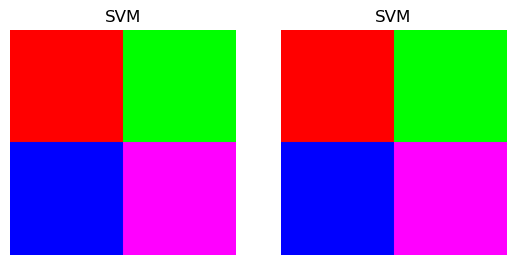

In [36]:
'''SVM'''
print('TRUE LABELS')
segmentate_classes(Cy_test, cv2.cvtColor(composed_images[0], cv2.COLOR_GRAY2RGBA), 'SVM')
print('---------------------------------------------------------')

PREDICTED LABELS
[['T1' 'T1' 'T1' 'T1' 'T4' 'T5' 'T2' 'T5']
 ['T1' 'T1' 'T1' 'T1' 'T5' 'T2' 'T5' 'T2']
 ['T1' 'T1' 'T1' 'T1' 'T4' 'T5' 'T2' 'T5']
 ['T1' 'T1' 'T1' 'T1' 'T4' 'T5' 'T5' 'T2']
 ['T4' 'T5' 'T4' 'T5' 'T2' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T2']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T4' 'T6' 'T6' 'T6' 'T6']]


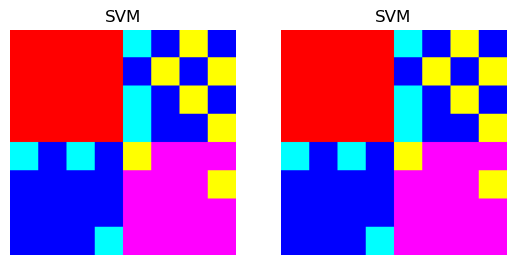

In [37]:
print('PREDICTED LABELS')
y_pred_svm = SVM_model.predict(CX_features_test)
segmentate_classes(y_pred_svm, cv2.cvtColor(composed_images[0], cv2.COLOR_GRAY2RGBA), 'SVM')

KNN

TRUE LABELS
[['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']]
---------------------------------------------------------


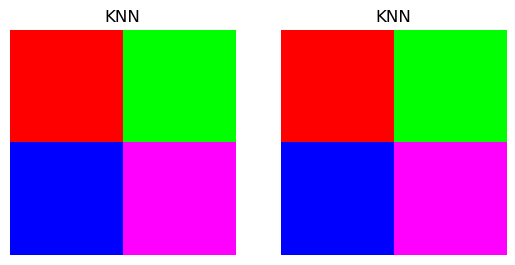

In [38]:
'''KNN'''
print('TRUE LABELS')
segmentate_classes(Cy_test, cv2.cvtColor(composed_images[0], cv2.COLOR_GRAY2RGBA), 'KNN')
print('---------------------------------------------------------')

PREDICTED LABELS
[['T1' 'T1' 'T1' 'T1' 'T4' 'T3' 'T2' 'T5']
 ['T1' 'T1' 'T1' 'T1' 'T5' 'T2' 'T5' 'T2']
 ['T1' 'T1' 'T1' 'T1' 'T4' 'T3' 'T2' 'T5']
 ['T1' 'T1' 'T1' 'T1' 'T5' 'T3' 'T5' 'T2']
 ['T5' 'T5' 'T4' 'T5' 'T2' 'T2' 'T2' 'T2']
 ['T5' 'T5' 'T5' 'T5' 'T2' 'T2' 'T2' 'T2']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T2' 'T2' 'T2']
 ['T5' 'T5' 'T5' 'T4' 'T2' 'T6' 'T6' 'T2']]


/Users/rcs/opt/anaconda3/envs/REC-PATRONES/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


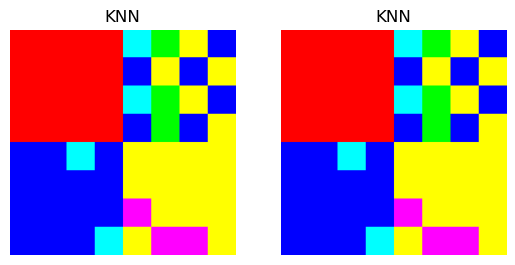

In [39]:
print('PREDICTED LABELS')
y_pred_knn = neigh.predict(CX_features_test,)
segmentate_classes(y_pred_knn, cv2.cvtColor(composed_images[0], cv2.COLOR_GRAY2RGBA), 'KNN')

NAIVE BAYES 

TRUE LABELS
[['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']]
---------------------------------------------------------


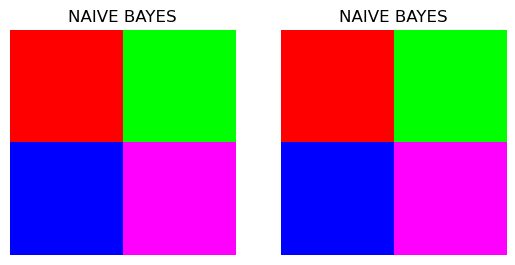

In [40]:
'''KNN'''
print('TRUE LABELS')
segmentate_classes(Cy_test, cv2.cvtColor(composed_images[0], cv2.COLOR_GRAY2RGBA), 'NAIVE BAYES')
print('---------------------------------------------------------')

PREDICTED LABELS
[['T1' 'T1' 'T1' 'T1' 'T4' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T5' 'T3' 'T3' 'T3']
 ['T1' 'T1' 'T1' 'T1' 'T3' 'T3' 'T3' 'T3']
 ['T4' 'T5' 'T4' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T5' 'T6' 'T6' 'T6' 'T6']
 ['T5' 'T5' 'T5' 'T4' 'T6' 'T6' 'T6' 'T6']]


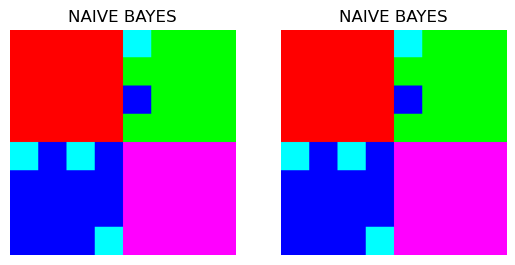

In [41]:
print('PREDICTED LABELS')
y_pred_nv = clf.predict(CX_features_test)
segmentate_classes(y_pred_nv, cv2.cvtColor(composed_images[0], cv2.COLOR_GRAY2RGBA), 'NAIVE BAYES')